In [28]:
import os
import bs4
import json
import requests
import matplotlib.pyplot as plt
from pprint import pprint
from dotenv import load_dotenv
from IPython.display import Image

In [2]:
load_dotenv() # Gets env variables (API access token)
THEMOVIEDB_ACCESS_TOKEN = os.getenv("THEMOVIEDB_ACCESS_TOKEN")

In [3]:
headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {THEMOVIEDB_ACCESS_TOKEN}"
}

In [4]:
# Gets movies with matching title and year
title = "sound of freedom".replace(" ", "%20")
year = "2023"

url = f"https://api.themoviedb.org/3/search/movie?query={title}&include_adult=false&language=en-US&page=1&year={year}"
matching_movies = json.loads(requests.get(url, headers=headers).text)
pprint(matching_movies)

{'page': 1,
 'results': [{'adult': False,
              'backdrop_path': '/pA3vdhadJPxF5GA1uo8OPTiNQDT.jpg',
              'genre_ids': [28, 18],
              'id': 678512,
              'original_language': 'en',
              'original_title': 'Sound of Freedom',
              'overview': 'The story of Tim Ballard, a former US government '
                          'agent, who quits his job in order to devote his '
                          'life to rescuing children from global sex '
                          'traffickers.',
              'popularity': 1271.779,
              'poster_path': '/qA5kPYZA7FkVvqcEfJRoOy4kpHg.jpg',
              'release_date': '2023-07-03',
              'title': 'Sound of Freedom',
              'video': False,
              'vote_average': 8.1,
              'vote_count': 926}],
 'total_pages': 1,
 'total_results': 1}


In [5]:
# Gets ID of best result
best_result = matching_movies["results"][0]
movie_id = best_result["id"]
print(movie_id)

678512


In [6]:
# Gets movie details by its ID
url = f"https://api.themoviedb.org/3/movie/{movie_id}?language=en-US"
movie_details = json.loads(requests.get(url, headers=headers).text)
pprint(movie_details)

{'adult': False,
 'backdrop_path': '/pA3vdhadJPxF5GA1uo8OPTiNQDT.jpg',
 'belongs_to_collection': None,
 'budget': 15000000,
 'genres': [{'id': 28, 'name': 'Action'}, {'id': 18, 'name': 'Drama'}],
 'homepage': 'https://www.soundoffreedommovie.com/',
 'id': 678512,
 'imdb_id': 'tt7599146',
 'original_language': 'en',
 'original_title': 'Sound of Freedom',
 'overview': 'The story of Tim Ballard, a former US government agent, who '
             'quits his job in order to devote his life to rescuing children '
             'from global sex traffickers.',
 'popularity': 1271.779,
 'poster_path': '/qA5kPYZA7FkVvqcEfJRoOy4kpHg.jpg',
 'production_companies': [{'id': 90508,
                           'logo_path': None,
                           'name': 'Santa Fe Films',
                           'origin_country': 'US'}],
 'production_countries': [{'iso_3166_1': 'US',
                           'name': 'United States of America'}],
 'release_date': '2023-07-03',
 'revenue': 238000000,
 'runtime

In [7]:
# Gets alternative titles
url = "https://api.themoviedb.org/3/movie/678512/alternative_titles?country=BR"
alternative_title = json.loads(requests.get(url, headers=headers).text)['titles'][0]['title']
pprint(alternative_title)

'Som da Liberdade'


In [8]:
# Gets a list of posters
url = f"https://api.themoviedb.org/3/movie/{movie_id}/images?language=en"

# Gets paths to all images
images = json.loads(requests.get(url, headers=headers).text)

# Only poster
posters = images['posters']

# Assuming the first poster is the 'best' image
poster_path = posters[0]['file_path']

In [9]:
# Gets the poster
url = f"https://image.tmdb.org/t/p/original/{poster_path}"
poster = requests.get(url, headers=headers).content

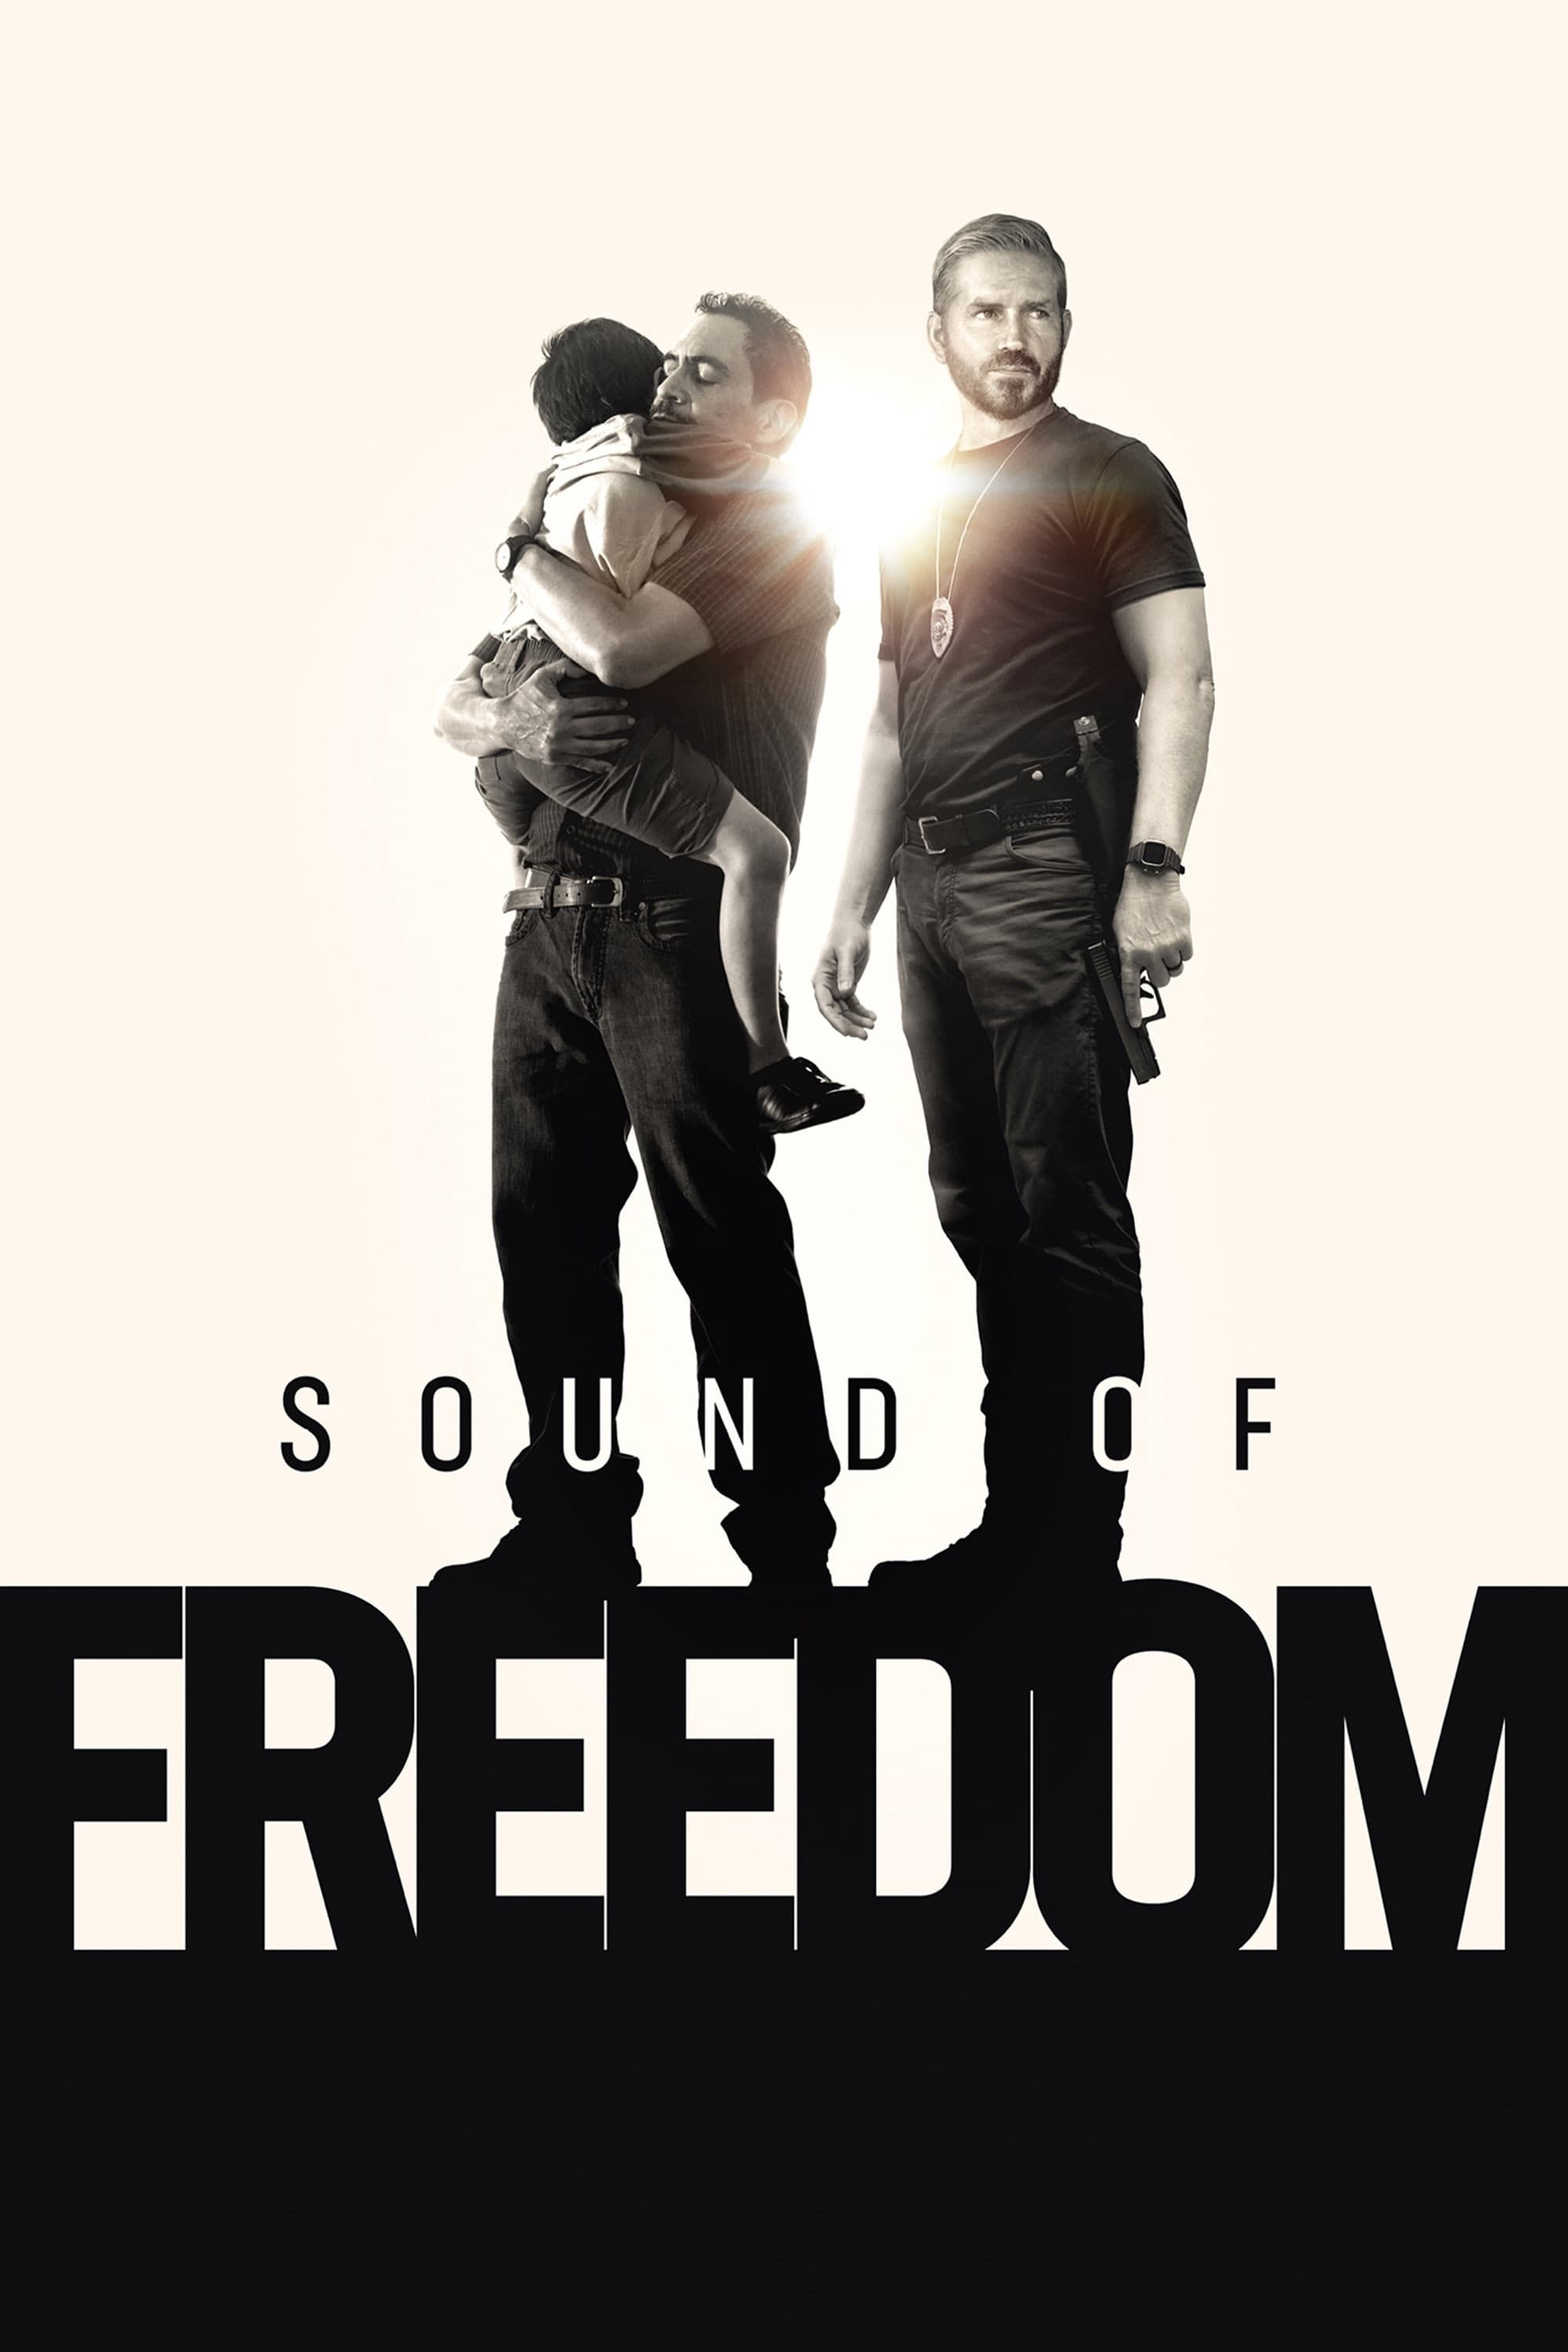

In [10]:
# Shows the poster
with open(f"{movie_id}.jpg", "wb") as file:
    file.write(poster)
Image(filename=f"{movie_id}.jpg", width=200)

In [11]:
# Get box office page from Box Office Mojo
url = "https://www.boxofficemojo.com/title/tt7599146/"
box_office_page = requests.get(url)

In [51]:
# Use bs4 to get this selector: #a-page > main > div > div.a-section.a-spacing-none.a-spacing-top-base > div > div > table:nth-child(2)
soup = bs4.BeautifulSoup(box_office_page.text, 'html.parser')
performances_by_region = {
    'Domestic': soup.select("#a-page > main > div > div.a-section.a-spacing-none.a-spacing-top-base > div > div > table:nth-child(2)"),
    'Europe, Middle East and East Africa': soup.select("#a-page > main > div > div.a-section.a-spacing-none.a-spacing-top-base > div > div > table:nth-child(4)"),
    'Latin America': soup.select("#a-page > main > div > div.a-section.a-spacing-none.a-spacing-top-base > div > div > table:nth-child(6)"),
    'Asian Pacific': soup.select("#a-page > main > div > div.a-section.a-spacing-none.a-spacing-top-base > div > div > table:nth-child(8)"),
}

country_data = []

for region in performances_by_region:
    test_performance = performances_by_region[region]
    table = test_performance[0]
    rows = table.find_all('tr')[1:]

    # Iterate through the rows and extract information for each country
    for i_row, row in enumerate(rows):
        print(f"\nROW {i_row})")
        columns = row.find_all('td')
        for i_column, column in enumerate(columns):
            column_raw_text = str(column).replace("\n", "")
            column_value = column.get_text(strip=True)
            print(f"--> (COLUMN {i_column}) {column_value}")
        try:
            country = columns[0].get_text(strip=True)
            release_date = columns[1].get_text(strip=True)
            opening = columns[2].get_text(strip=True)
            gross = columns[3].find('span', class_='money').get_text(strip=True)

            country_data.append({
                'country': country,
                'release_date': release_date,
                'opening': opening,
                'gross': gross,
                'region': region
            })
        except Exception as exception:
            print(f"--> ERROR: {exception}")

country_data[0]['country'] = 'US, Canada and Puerto Rico'
for i, country in enumerate(country_data):
    for key, value in country.items():
        if value == '–':
            country_data[i][key] = None


ROW 0)
--> (COLUMN 0) Domestic
--> (COLUMN 1) Jul 4, 2023
--> (COLUMN 2) $19,680,879
--> (COLUMN 3) $184,072,726

ROW 0)
--> (COLUMN 0) United Kingdom
--> (COLUMN 1) Sep 1, 2023
--> (COLUMN 2) $956,748
--> (COLUMN 3) $2,720,566

ROW 1)
--> (COLUMN 0) Saudi Arabia
--> (COLUMN 1) Aug 14, 2023
--> (COLUMN 2) –
--> (COLUMN 3) $2,165,925

ROW 2)
--> (COLUMN 0) Spain
--> (COLUMN 1) Oct 13, 2023
--> (COLUMN 2) $628,743
--> (COLUMN 3) $1,007,135

ROW 3)
--> (COLUMN 0) United Arab Emirates
--> (COLUMN 1) Aug 17, 2023
--> (COLUMN 2) $153,695
--> (COLUMN 3) $836,096

ROW 4)
--> (COLUMN 0) South Africa
--> (COLUMN 1) Aug 18, 2023
--> (COLUMN 2) $87,927
--> (COLUMN 3) $374,293

ROW 5)
--> (COLUMN 0) Croatia
--> (COLUMN 1) Aug 31, 2023
--> (COLUMN 2) $73,698
--> (COLUMN 3) $290,835

ROW 6)
--> (COLUMN 0) Nigeria
--> (COLUMN 1) Aug 18, 2023
--> (COLUMN 2) –
--> (COLUMN 3) $276,058

ROW 7)
--> (COLUMN 0) South Africa/Nigeria
--> (COLUMN 1) Aug 18, 2023
--> (COLUMN 2) –
--> (COLUMN 3) $276,058

ROW 8)

In [52]:
country_data

[{'country': 'US, Canada and Puerto Rico',
  'release_date': 'Jul 4, 2023',
  'opening': '$19,680,879',
  'gross': '$184,072,726',
  'region': 'Domestic'},
 {'country': 'United Kingdom',
  'release_date': 'Sep 1, 2023',
  'opening': '$956,748',
  'gross': '$2,720,566',
  'region': 'Europe, Middle East and East Africa'},
 {'country': 'Saudi Arabia',
  'release_date': 'Aug 14, 2023',
  'opening': None,
  'gross': '$2,165,925',
  'region': 'Europe, Middle East and East Africa'},
 {'country': 'Spain',
  'release_date': 'Oct 13, 2023',
  'opening': '$628,743',
  'gross': '$1,007,135',
  'region': 'Europe, Middle East and East Africa'},
 {'country': 'United Arab Emirates',
  'release_date': 'Aug 17, 2023',
  'opening': '$153,695',
  'gross': '$836,096',
  'region': 'Europe, Middle East and East Africa'},
 {'country': 'South Africa',
  'release_date': 'Aug 18, 2023',
  'opening': '$87,927',
  'gross': '$374,293',
  'region': 'Europe, Middle East and East Africa'},
 {'country': 'Croatia',
  'r

In [56]:
'''
Format data:
    - country (no changes)
    - gross ('$4,687,226' --> float(4687226.0))
    - opening ('$415,942' --> float(415942.0))
    - release_date ('Jun 10, 2021' --> '10/06/2021')
'''

month_to_number = {
    'Jan': '01',
    'Feb': '02',
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep': '09',
    'Oct': '10',
    'Nov': '11',
    'Dec': '12',
}

country_data_formatted = []

# Formats data
for i, country in enumerate(country_data):
    print(f"\n{i}) {country['country']} ({country['region']})")
    current_gross = country['gross']
    current_opening = country['opening']
    current_release_date = country['release_date']
    new_gross = float(current_gross.replace("$", "").replace(",", ""))
    new_opening = float(current_opening.replace("$", "").replace(",", "")) if current_opening else None
    if current_release_date != None:
        new_release_date = current_release_date.replace(",", "").replace(" ", "/")
        new_release_date = new_release_date.split("/")
        day = new_release_date[1]
        month = month_to_number[new_release_date[0]]
        year = new_release_date[2]
        new_release_date = f"{day}/{month}/{year}"
    print(f"* gross: {current_gross} --> {new_gross}")
    print(f"* opening: {current_opening} --> {new_opening}")
    print(f"* release_date: {current_release_date} --> {new_release_date}")
    country_data_formatted.append({
        'country': country['country'],
        'gross': new_gross,
        'opening': new_opening,
        'release_date': new_release_date,
        'region': country['region']
    })


0) US, Canada and Puerto Rico (Domestic)
* gross: $184,072,726 --> 184072726.0
* opening: $19,680,879 --> 19680879.0
* release_date: Jul 4, 2023 --> 4/07/2023

1) United Kingdom (Europe, Middle East and East Africa)
* gross: $2,720,566 --> 2720566.0
* opening: $956,748 --> 956748.0
* release_date: Sep 1, 2023 --> 1/09/2023

2) Saudi Arabia (Europe, Middle East and East Africa)
* gross: $2,165,925 --> 2165925.0
* opening: None --> None
* release_date: Aug 14, 2023 --> 14/08/2023

3) Spain (Europe, Middle East and East Africa)
* gross: $1,007,135 --> 1007135.0
* opening: $628,743 --> 628743.0
* release_date: Oct 13, 2023 --> 13/10/2023

4) United Arab Emirates (Europe, Middle East and East Africa)
* gross: $836,096 --> 836096.0
* opening: $153,695 --> 153695.0
* release_date: Aug 17, 2023 --> 17/08/2023

5) South Africa (Europe, Middle East and East Africa)
* gross: $374,293 --> 374293.0
* opening: $87,927 --> 87927.0
* release_date: Aug 18, 2023 --> 18/08/2023

6) Croatia (Europe, Midd

In [57]:
country_data_formatted

[{'country': 'US, Canada and Puerto Rico',
  'gross': 184072726.0,
  'opening': 19680879.0,
  'release_date': '4/07/2023',
  'region': 'Domestic'},
 {'country': 'United Kingdom',
  'gross': 2720566.0,
  'opening': 956748.0,
  'release_date': '1/09/2023',
  'region': 'Europe, Middle East and East Africa'},
 {'country': 'Saudi Arabia',
  'gross': 2165925.0,
  'opening': None,
  'release_date': '14/08/2023',
  'region': 'Europe, Middle East and East Africa'},
 {'country': 'Spain',
  'gross': 1007135.0,
  'opening': 628743.0,
  'release_date': '13/10/2023',
  'region': 'Europe, Middle East and East Africa'},
 {'country': 'United Arab Emirates',
  'gross': 836096.0,
  'opening': 153695.0,
  'release_date': '17/08/2023',
  'region': 'Europe, Middle East and East Africa'},
 {'country': 'South Africa',
  'gross': 374293.0,
  'opening': 87927.0,
  'release_date': '18/08/2023',
  'region': 'Europe, Middle East and East Africa'},
 {'country': 'Croatia',
  'gross': 290835.0,
  'opening': 73698.0,


In [58]:
# Definition of Movie class
class Movie:
    def __init__(self, id, title, alternative_title, budget, revenue, genres, homepage, imdb_id, original_language, 
                 original_title, overview, production_companies, production_countries, release_date, runtime,
                 country_data):
        self.id = id
        self.title = title
        self.alternative_title = alternative_title
        self.budget = budget
        self.revenue = revenue
        self.genres = genres
        self.homepage = homepage
        self.imdb_id = imdb_id
        self.imdb_link = self.get_imdb_link(imdb_id)
        self.original_language = original_language
        self.original_title = original_title
        self.overview = overview
        self.production_companies = production_companies
        self.production_countries = production_countries
        self.release_date = release_date
        self.runtime = runtime
        self.country_data = country_data

        print(f"*** Movie created")
        print(f"--> Title: {self.title}")
        print(f"--> Alternative title: {self.alternative_title}")
        print(f"--> Original language: {self.original_language}")
        print(f"--> Homepage: {self.homepage}")
        print(f"--> IMDB link: {self.imdb_link}")

    @staticmethod    
    def get_imdb_link(imdb_id):
        imdb_link = f"https://www.imdb.com/title/{imdb_id}/"
        return imdb_link

# Creates Movie object
sound_of_freedom = Movie(
    id=movie_details["id"],
    title=movie_details["title"],
    alternative_title=alternative_title,
    budget=movie_details["budget"],
    revenue=movie_details["revenue"],
    genres=movie_details["genres"],
    homepage=movie_details["homepage"],
    imdb_id=movie_details["imdb_id"],
    original_language=movie_details["original_language"],
    original_title=movie_details["original_title"],
    overview=movie_details["overview"],
    production_companies=movie_details["production_companies"],
    production_countries=movie_details["production_countries"],
    release_date=movie_details["release_date"],
    runtime=movie_details["runtime"],
    country_data=country_data_formatted
)

*** Movie created
--> Title: Sound of Freedom
--> Alternative title: Som da Liberdade
--> Original language: en
--> Homepage: https://www.soundoffreedommovie.com/
--> IMDB link: https://www.imdb.com/title/tt7599146/


In [111]:
all_countries_data = [entry for entry in sound_of_freedom.country_data]
domestic_country_data = [entry for entry in all_countries_data if entry['region'] == 'Domestic']
latin_america_country_data = [entry for entry in all_countries_data if entry['region'] == 'Latin America']
europe_mid_east_east_africa_country_data = [entry for entry in all_countries_data if entry['region'] == 'Europe, Middle East and East Africa']
asian_pacific_country_data = [entry for entry in all_countries_data if entry['region'] == 'Asian Pacific']

In [112]:
def plot_gross_and_opening(countries, gross_values, opening_values):
    # Replace None values with 0
    gross_values = [0 if value == None else value for value in gross_values]
    opening_values = [0 if value == None else value for value in opening_values]

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a bar plot for gross
    ax.bar(countries, gross_values, label='Total', color='skyblue')
    # Create a bar plot for opening
    ax.bar(countries, opening_values, label='Estreia', color='orange', alpha=0.7)

    # Set labels and title
    ax.set_xlabel('País')
    ax.set_ylabel('Valor ($)')
    ax.set_title('Receita total e de estreia por país')
    ax.legend()

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()

def plot_gross_pie(countries, gross_values, opening_values):
    # Replace None values with 0
    gross_values = [0 if value == None else value for value in gross_values]
    opening_values = [0 if value == None else value for value in opening_values]

    # Create a pie chart
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(gross_values, labels=countries, autopct='%1.1f%%', startangle=90, shadow=True)

    # Set the aspect ratio to be equal to ensure a circular pie chart
    ax.axis('equal')

    # Set the title
    ax.set_title('Distribuição de receita por país')

    # Show the plot
    plt.show()

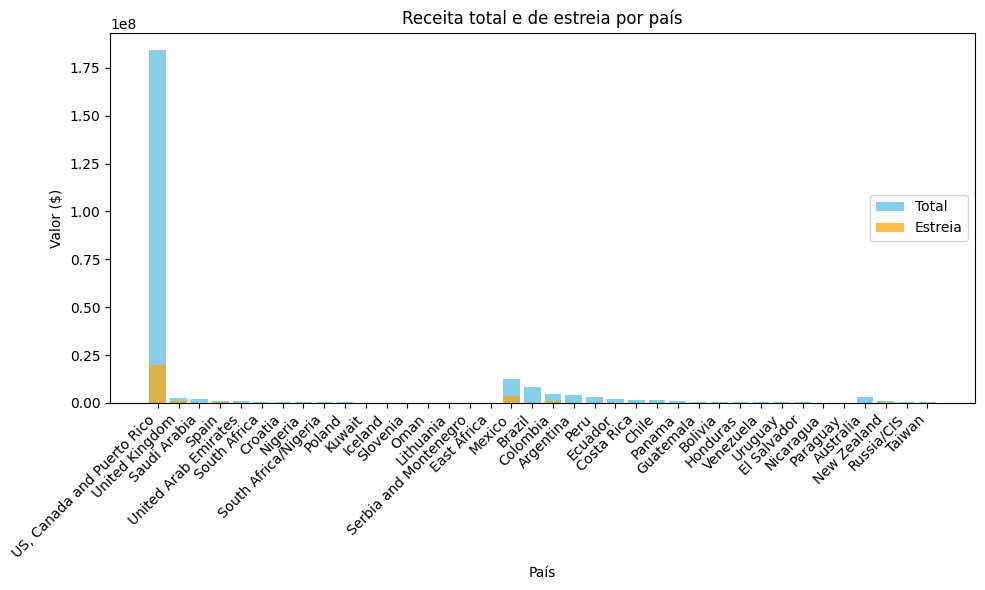

In [115]:
plot_gross_and_opening(
    countries=[entry['country'] for entry in all_countries_data],
    gross_values=[entry['gross'] for entry in all_countries_data],
    opening_values=[entry['opening'] for entry in all_countries_data]
)

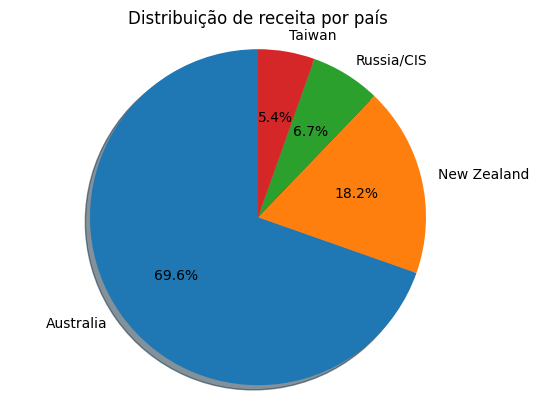

In [116]:
plot_gross_pie(
    countries=[entry['country'] for entry in asian_pacific_country_data],
    gross_values=[entry['gross'] for entry in asian_pacific_country_data],
    opening_values=[entry['opening'] for entry in asian_pacific_country_data]
)

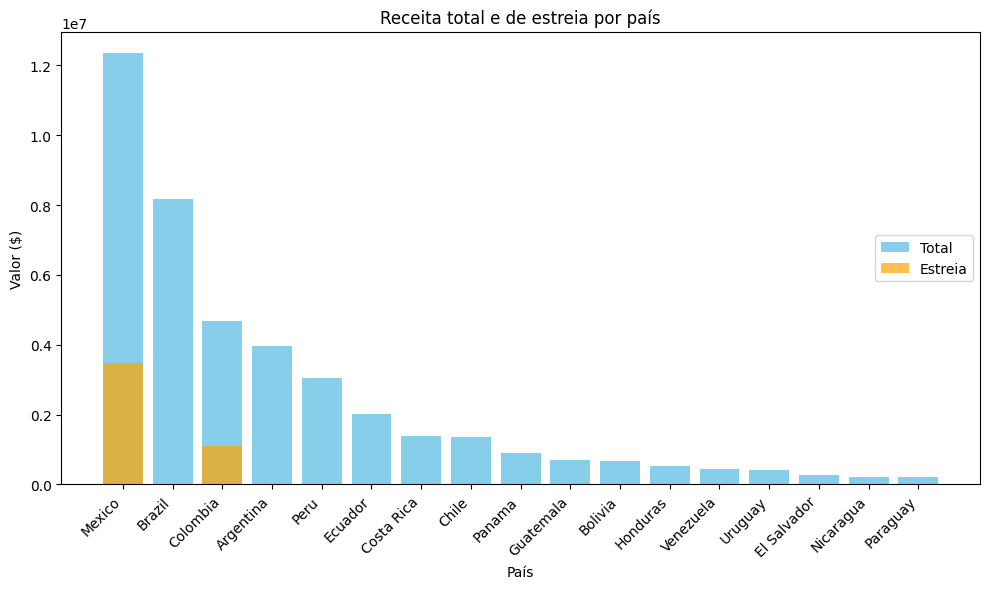

In [117]:
plot_gross_and_opening(
    countries=[entry['country'] for entry in latin_america_country_data],
    gross_values=[entry['gross'] for entry in latin_america_country_data],
    opening_values=[entry['opening'] for entry in latin_america_country_data]
)

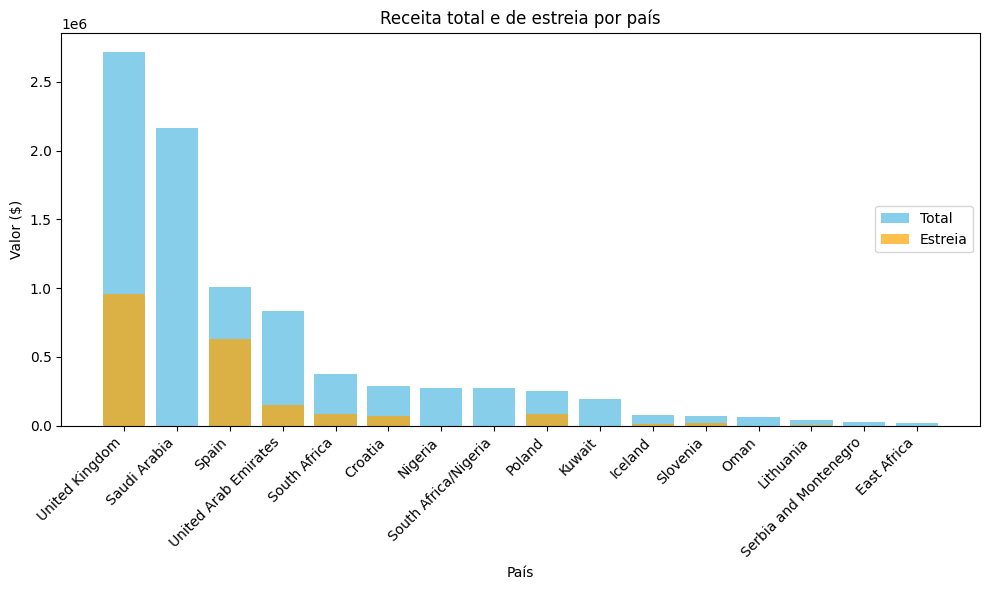

In [118]:
plot_gross_and_opening(
    countries=[entry['country'] for entry in europe_mid_east_east_africa_country_data],
    gross_values=[entry['gross'] for entry in europe_mid_east_east_africa_country_data],
    opening_values=[entry['opening'] for entry in europe_mid_east_east_africa_country_data]
)

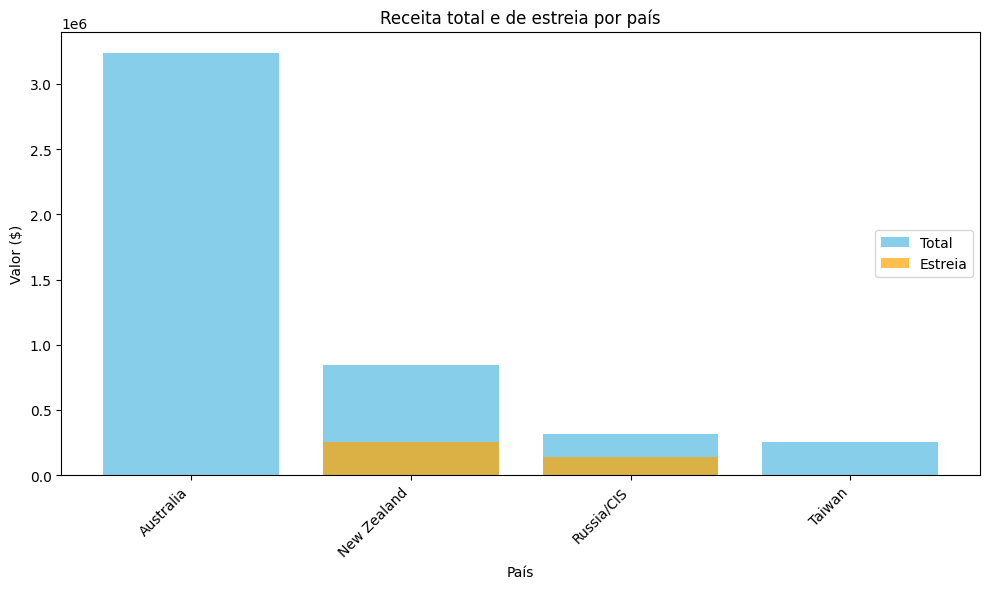

In [119]:
plot_gross_and_opening(
    countries=[entry['country'] for entry in asian_pacific_country_data],
    gross_values=[entry['gross'] for entry in asian_pacific_country_data],
    opening_values=[entry['opening'] for entry in asian_pacific_country_data]
)